## Initial Setup

The idea is to set up a basic end-to-end running code with augmentation, data loader, and visualization.

### Pipeline 
1. Data Loader abstracted to use separate augmentation file
2. Model moved to a separate file
3. Add Data Visualization module for Dataset and Incorrect Prediction

### Targets
1. Create a basic model which trains on MNIST Data
2. Create essential transformation using Albementation
3. Analyze Outputs

### Results
1. Prepared a network with **16,530** params
2. Trained for 15 Epochs and reached an accuracy of **99.91%** Train and **99.15%** Test

### Analysis
1. Network has more capacity to learn
2. Network is too extensive we have to optimize it to a smaller one
3. We can clearly see the network is Overfitting

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# The GPU id to use, "0" to  "7"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
from __future__ import print_function

In [6]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(1)

batch_size = 32
class_map = {
    'ZERO': 0,
    'ONE': 1,
    'TWO': 2,
    'THREE': 3,
    'FOUR': 4,
    'FIVE': 5,
    'SIX': 6,
    'SEVEN': 7,
    'EIGHT': 8,
    'NINE': 9
}
show_summary = True
show_dataset_analyze = False

In [7]:
# Load Network and Print Summary
from mnist.model import NetInitial
from mnist.utils import get_device, print_summary

# Check GPU availability
use_cuda, device = get_device()

if show_summary:
    model = NetInitial().to(device)
    print_summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
            Conv2d-2            [-1, 8, 24, 24]             584
         MaxPool2d-3            [-1, 8, 12, 12]               0
            Conv2d-4           [-1, 16, 12, 12]             144
            Conv2d-5           [-1, 16, 10, 10]           2,320
            Conv2d-6             [-1, 16, 8, 8]           2,320
         MaxPool2d-7             [-1, 16, 4, 4]               0
            Conv2d-8             [-1, 32, 4, 4]             544
            Conv2d-9             [-1, 32, 2, 2]           9,248
           Conv2d-10             [-1, 10, 1, 1]           1,290
Total params: 16,530
Trainable params: 16,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.06
Estimated Tot

In [8]:
from mnist.dataset import get_loader
from mnist.transform import get_a_train_transform, get_a_test_transform

train_loader, test_loader = get_loader(get_a_train_transform(), get_a_test_transform(), batch_size=batch_size, use_cuda=use_cuda)

In [9]:
## Calculate Class Scale
from mnist.visualize import print_class_scale, print_samples
if show_dataset_analyze:
    print_class_scale(train_loader, class_map)
    print_samples(train_loader)

In [10]:
import time
import math

from mnist.backpropagation import train, test, get_sgd_optimizer
from mnist.utils import initialize_weights
from mnist.scheduler import one_cycle_lr_pt, one_cycle_lr_custom
from mnist.training import Training

# Train Params
epochs = 15
lr = 0.01
max_lr = 0.01 #0.1
steps_per_epoch = len(train_loader)
dropout = True
momentum = 0.9
weight_decay = 0

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("\n")

model = NetInitial().apply(initialize_weights).to(device)
optimizer = get_sgd_optimizer(model, lr=lr)

# Pytorch one cycle scheduler
pytorch_scheduler = one_cycle_lr_pt(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

# One cycle schedule with a custom function
custom_scheduler = one_cycle_lr_custom(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

trainer = Training(
    model,
    optimizer,
    pytorch_scheduler,
    train(),
    test,
    train_loader,
    test_loader,
    lr,
    epochs,
    device,
    dropout
)

trainer.run()

Using Device: cuda
Epochs: 15
Lr: 0.01
Max Lr: 0.01
Batch Size: 32
Dropout: True


| Epoch | LR       | Time    | TrainLoss | TrainCorrect | TrainAcc | ValLoss  | ValCorrect | ValAcc |
|     1 | 0.010000 | 00m 11s | 0.578923  |        48272 | 80.45  % | 0.128561 |       9623 | 96.23% |
|     2 | 0.002534 | 00m 10s | 0.097078  |        58204 | 97.01  % | 0.061427 |       9796 | 97.96% |
|     3 | 0.004667 | 00m 10s | 0.069356  |        58728 | 97.88  % | 0.059053 |       9810 | 98.1 % |
|     4 | 0.006801 | 00m 11s | 0.055934  |        58936 | 98.23  % | 0.044168 |       9852 | 98.52% |
|     5 | 0.008934 | 00m 11s | 0.047059  |        59110 | 98.52  % | 0.042165 |       9866 | 98.66% |
|     6 | 0.009523 | 00m 10s | 0.039738  |        59247 | 98.75  % | 0.041785 |       9868 | 98.68% |
|     7 | 0.008571 | 00m 11s | 0.033531  |        59365 | 98.94  % | 0.032883 |       9898 | 98.98% |
|     8 | 0.007619 | 00m 11s | 0.028518  |        59476 | 99.13  % | 0.039894 |       9880 | 98.8 % |

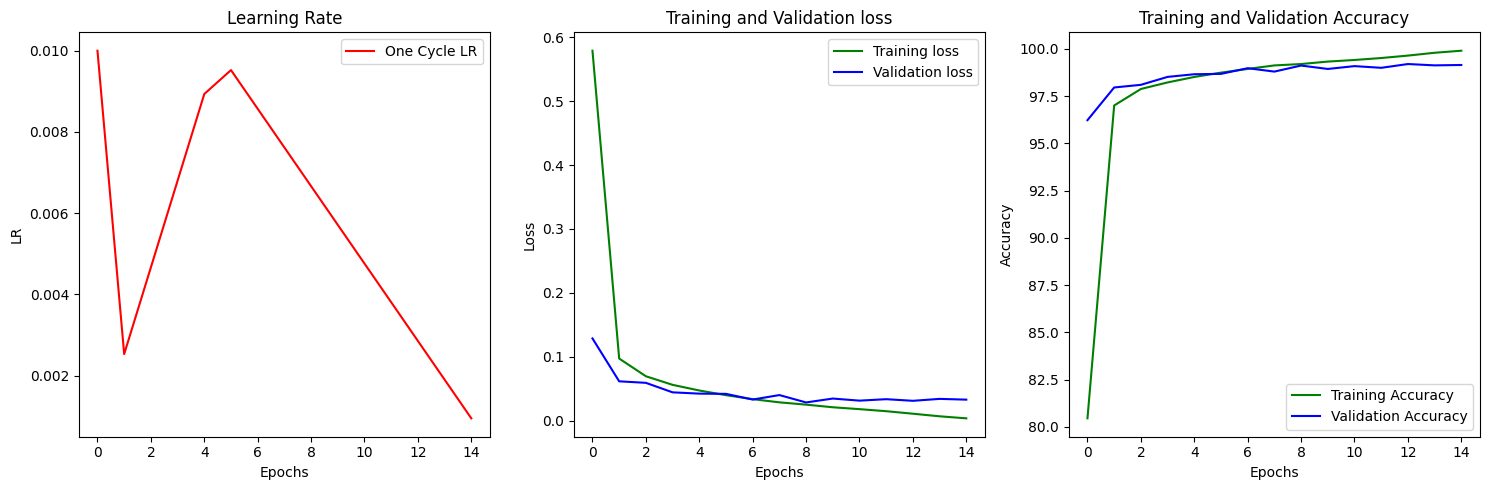

In [11]:
from mnist.visualize import plot_network_performance

# trainer.print_best_model()
plot_network_performance(epochs, trainer.schedule, trainer.list_train_loss, trainer.list_valid_loss, trainer.list_train_correct, trainer.list_valid_correct)

## Analyze Network

Confusion matrix, without normalization


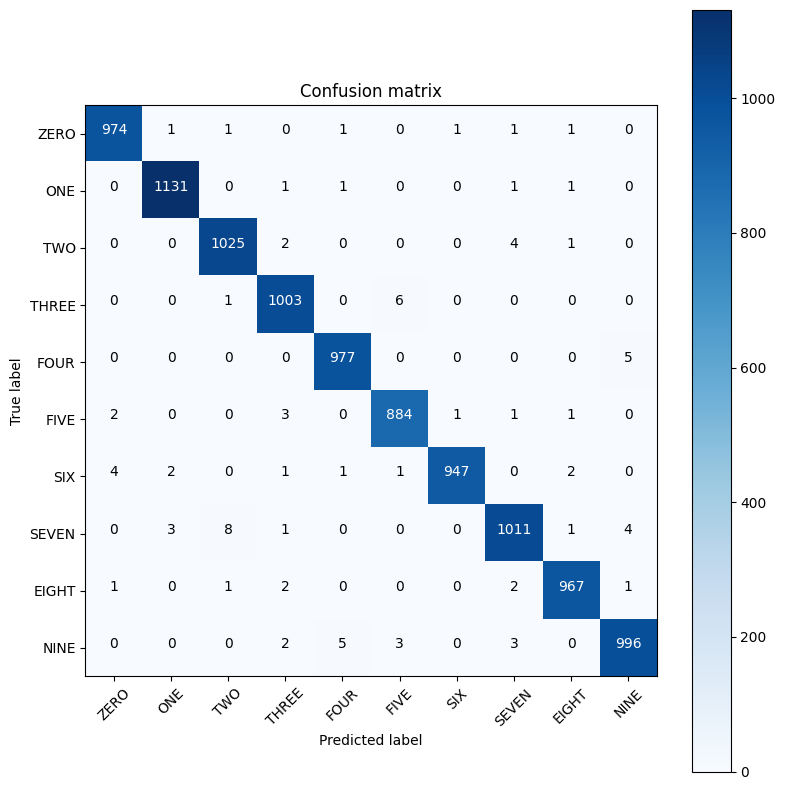

In [12]:
from mnist.utils import get_all_predictions, get_incorrrect_predictions, prepare_confusion_matrix
from mnist.visualize import plot_confusion_matrix

all_preds, all_targets = get_all_predictions(model, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
plot_confusion_matrix(confusion_matrix, class_map, False)

Total Incorrect Predictions 85


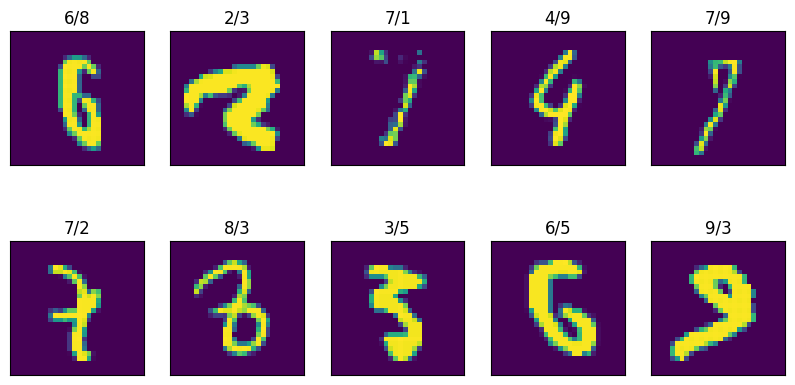

In [13]:
from mnist.utils import get_incorrrect_predictions
from mnist.visualize import plot_incorrect_predictions

incorrect = get_incorrrect_predictions(model, test_loader, device)
plot_incorrect_predictions(incorrect, class_map)